In [144]:
# Set up helper functions
from sensor_msgs.msg import JointState
from std_msgs.msg import Float64MultiArray
import rosbag
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# master loader for the bag, returns the messages on topic_name in time order
def bag_loader(path, map_and_append_msg, topic_name = 'robot_state', normalize = ''):
    # map_and_append_msgs is a function handle which should be written for each type.  There are some for joint state and robot state below
    bag = rosbag.Bag(path)
    num_obs = bag.get_message_count(topic_name)
    if num_obs is 0:
        topic_name = '/'+topic_name
        num_obs = bag.get_message_count(topic_name)
    print('Loading ros bag {}  with {} msgs on topic {}'.format(path, num_obs, topic_name))

    msgs = {}
    t = []
    for _, msg, t_ros in bag.read_messages(topics=[topic_name]):
        t.append(t_ros.to_sec())
        map_and_append_msg(msg, msgs)
    #t = [tt-t[0] for tt in t]
    #t = [tt for tt in t]
    #print(len(msgs['pos']))

    msgs_in_order = {}
    for key in msgs.keys():
        #print(t)
        #print(msgs)
        t_in_order, el_in_order = zip(*sorted(zip(t,msgs[key])))
        msgs_in_order[key] = np.array(el_in_order).T
    msgs_in_order['t'] = t_in_order
    
    if normalize is not '':
        msgs_in_order[normalize] = (msgs_in_order[normalize].T-msgs_in_order[normlize][:,0]).T
        
    return msgs_in_order

def get_aligned_msgs(msgs1, msgs2):
    ''' 
    Select entries from msgs2 which occured most recently before msgs1
    '''
    aligned_msgs2 = {key:[] for key in msgs2.keys()}
    t2 = np.array(msgs2['t'])
    for t1 in msgs1['t']:
        last_before_t1 = np.where(t2<=t1)[0][-1] # find last time in t which is 
        for key in msgs2.keys():
            if key == 't': continue
            aligned_msgs2[key].append(msgs2[key][:,last_before_t1])

    for key in msgs2.keys():
        aligned_msgs2[key] = np.array(aligned_msgs2[key]).T
    
    return aligned_msgs2

def map_robot_state(msg, prev_msgs):
    if len(prev_msgs) is 0:
        for el in ('pos', 'vel', 'force'):
            prev_msgs[el] = []
    prev_msgs['pos'].append(msg.position)
    prev_msgs['vel'].append(msg.velocity)
    prev_msgs['force'].append(msg.effort)
    return prev_msgs


def map_joint_state(msg, prev_msgs):
    if len(prev_msgs) is 0:
        for el in ('pos', 'name'):
            prev_msgs[el] = []
    prev_msgs['pos'].append(msg.position)
    prev_msgs['name'].append(msg.name)
    return prev_msgs

def map_wrench(msg, prev_msgs):
    #print(f"Debug: {len(prev_msgs)}")
    if len(prev_msgs) is 0:
        prev_msgs['force'] = []
        prev_msgs['torque'] = []
    prev_msgs['force'].append(np.array([msg.wrench.force.x, 
                                        msg.wrench.force.y,
                                        msg.wrench.force.z]))
    prev_msgs['torque'].append(np.array([msg.wrench.torque.x, 
                                        msg.wrench.torque.y,
                                        msg.wrench.torque.z]))
    return prev_msgs

def map_point_msgs(msg, prev_msgs):
    #print(f"Debug: {len(prev_msgs)}")
    if len(prev_msgs) is 0:
        prev_msgs['position'] = []
    #print(f"Debug: {msg.pose.__dir__()}")
    prev_msgs['position'].append(np.array([msg.pose.position.x, 
                                        msg.pose.position.y,
                                        msg.pose.position.z]))
    return prev_msgs
    

def map_impedance_gains(msg, prev_msgs):
    if len(prev_msgs) is 0:
        for el in ('K', 'B', 'M', 'Fd'):
            prev_msgs[el] = []
    prev_msgs['K'].append(msg.position)
    prev_msgs['B'].append(msg.velocity)
    prev_msgs['M'].append(msg.effort[:len(msg.position)])
    prev_msgs['Fd'].append(msg.effort[len(msg.position):])

def map_delta_impedance_gains(msg, prev_msgs):
    if len(prev_msgs) is 0:
        for el in ('dK', 'dB', 'dM', 'Fd'):
            prev_msgs[el] = []
    prev_msgs['dK'].append(msg.position)
    prev_msgs['dB'].append(msg.velocity)
    prev_msgs['dM'].append(msg.effort[:len(msg.position)])
    prev_msgs['Fd'].append(msg.effort[len(msg.position):])
    

<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:36: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:59: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:69: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:78: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:91: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:101: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:110: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:36: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:59: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:69: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:78: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:91: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:101: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:110: SyntaxWarning: "is" with a literal. Did you mean "=

In [145]:
import yaml
from rosbag.bag import Bag
bag_path = '/home/christian/Projects/contact_monitoring/data/plug_threading_online.bag'
bag_dict = yaml.load(Bag(bag_path, 'r')._get_yaml_info(), Loader=yaml.Loader)
print("Keys are")
for k in bag_dict['topics']:
    #print(f"\n{k}:\n{bag_dict[k]}")
    print(f"\n:\n{k}")


Keys are

:
{'topic': '/cartesian_compliance_controller/parameter_descriptions', 'type': 'dynamic_reconfigure/ConfigDescription', 'messages': 1}

:
{'topic': '/cartesian_compliance_controller/parameter_updates', 'type': 'dynamic_reconfigure/Config', 'messages': 1}

:
{'topic': '/cartesian_compliance_controller/pd_gains/rot_x/parameter_descriptions', 'type': 'dynamic_reconfigure/ConfigDescription', 'messages': 1}

:
{'topic': '/cartesian_compliance_controller/pd_gains/rot_x/parameter_updates', 'type': 'dynamic_reconfigure/Config', 'messages': 1}

:
{'topic': '/cartesian_compliance_controller/pd_gains/rot_y/parameter_descriptions', 'type': 'dynamic_reconfigure/ConfigDescription', 'messages': 1}

:
{'topic': '/cartesian_compliance_controller/pd_gains/rot_y/parameter_updates', 'type': 'dynamic_reconfigure/Config', 'messages': 1}

:
{'topic': '/cartesian_compliance_controller/pd_gains/rot_z/parameter_descriptions', 'type': 'dynamic_reconfigure/ConfigDescription', 'messages': 1}

:
{'topic':

In [160]:
### Comparing with and without variance in contact
# %matplotlib

#topics
#'contact_mode': JointState message with name, position where positoin is the similarity
#'wrench' # WrenchStamped FT measurements
#'target_frame', # desired pose for admittance ctrl
#'target_wrench', # desired force for admittance trl
         

path = '/home/christian/Projects/contact_monitoring/data/'
bag = 'online_cable_threading_1.bag'
#bag = 'online_threading_cable_2a.bag'

contact_state_msgs = bag_loader(path+bag, map_joint_state, topic_name = 'contact_mode')
FT_msgs = bag_loader(path+bag, map_wrench, topic_name = 'wrench')
des_FT_msgs = bag_loader(path+bag, map_wrench, topic_name = 'target_wrench')
des_pose_msgs = bag_loader(path+bag, map_point_msgs, topic_name = 'target_frame')

Loading ros bag /home/christian/Projects/contact_monitoring/data/online_cable_threading_1.bag  with 19979 msgs on topic /contact_mode
Loading ros bag /home/christian/Projects/contact_monitoring/data/online_cable_threading_1.bag  with 21840 msgs on topic /wrench
Loading ros bag /home/christian/Projects/contact_monitoring/data/online_cable_threading_1.bag  with 19982 msgs on topic /target_wrench
Loading ros bag /home/christian/Projects/contact_monitoring/data/online_cable_threading_1.bag  with 19983 msgs on topic /target_frame


In [161]:
#load data
FT_f = FT_msgs['force']
FT_t = FT_msgs['torque']
Des_pos = des_pose_msgs['position']

Contact = contact_state_msgs['pos']
#time (offset by min t_start)
time_contact = list(contact_state_msgs['t'])
time_FT = np.array(list(FT_msgs['t']))

time_des_pos = np.array(list(des_pose_msgs['t']))
t_start = min(min(time_FT),min(time_contact),min(time_des_pos))
time_des_pos -= t_start

#t_start = min(min(time_FT),min(time_contact))
time_contact -= t_start
time_FT -= t_start


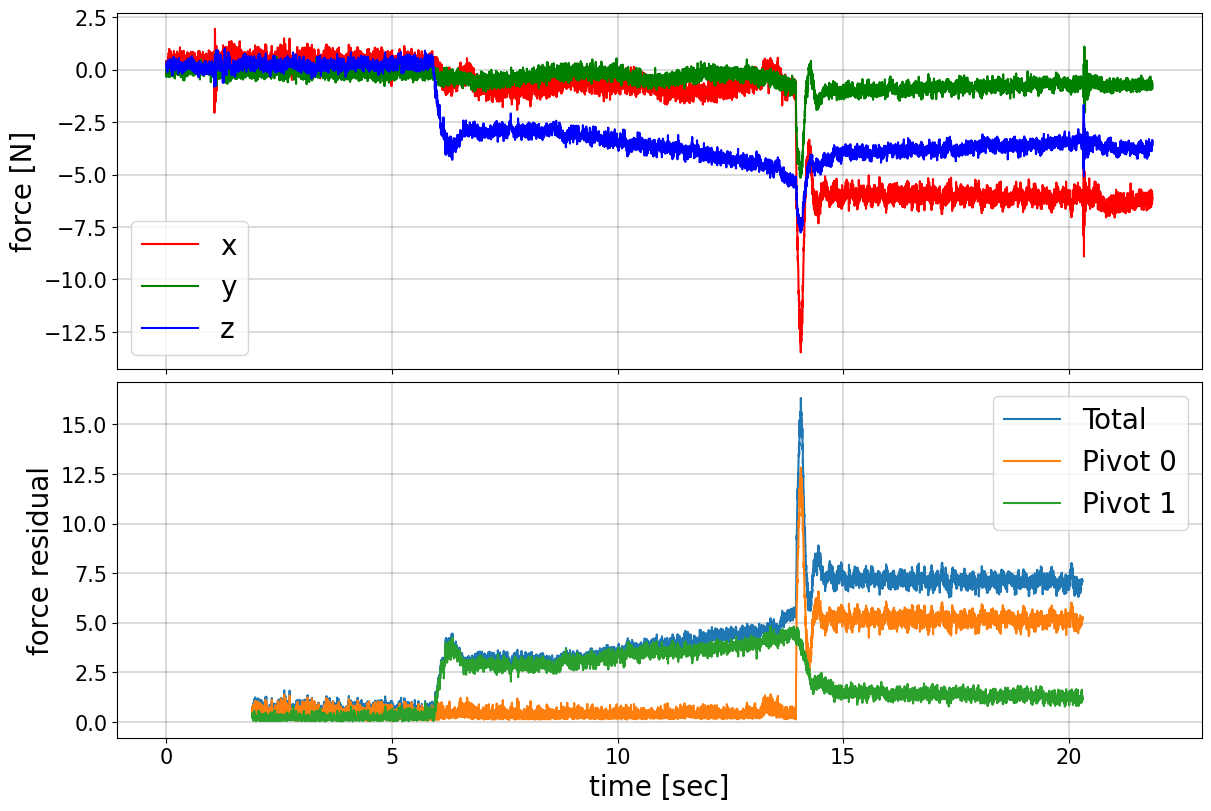

In [175]:
fig, ax = plt.subplots(2, 1, sharex=True,figsize=(12,8), constrained_layout=True)

ax[0].plot(time_FT, FT_f[0,:], color='r', label= "x")
ax[0].plot(time_FT, FT_f[1,:], color='g', label= "y")
ax[0].plot(time_FT, FT_f[2,:], color='b', label= "z")
ax[0].set_ylabel("force [N]", fontsize=20)

"""
ax[1].plot(time_FT, FT_t[0,:], label= "x")
ax[1].plot(time_FT, FT_t[1,:], label= "y")
ax[1].plot(time_FT, FT_t[2,:], label= "z")
ax[1].set_ylabel("torque [Nm]", fontsize=20)
"""

"""
ax[1].plot(time_des_pos, Des_pos[0,:], label= "x")
ax[1].plot(time_des_pos, Des_pos[1,:], label= "y")
ax[1].plot(time_des_pos, Des_pos[2,:], label= "z")
ax[1].set_ylabel("des pose [m]", fontsize=20)
"""

ax[1].plot(time_contact, Contact[0,:], label="Total")
ax[1].plot(time_contact, Contact[1,:], label="Pivot 0")
ax[1].plot(time_contact, Contact[2,:], label="Pivot 1")
ax[1].set_xlabel("time [sec]", fontsize=20)
ax[1].set_ylabel("force residual", fontsize=20)


for i in range(2):
    ax[i].legend(fontsize=20)
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[i].grid(color='black', linestyle='-', linewidth=.2)


plt.show()

Loading ros bag /home/christian/Projects/contact_monitoring/data/online_rake_1.bag  with 8327 msgs on topic /contact_mode
Loading ros bag /home/christian/Projects/contact_monitoring/data/online_rake_1.bag  with 14373 msgs on topic /wrench
Loading ros bag /home/christian/Projects/contact_monitoring/data/online_rake_1.bag  with 8324 msgs on topic /target_wrench


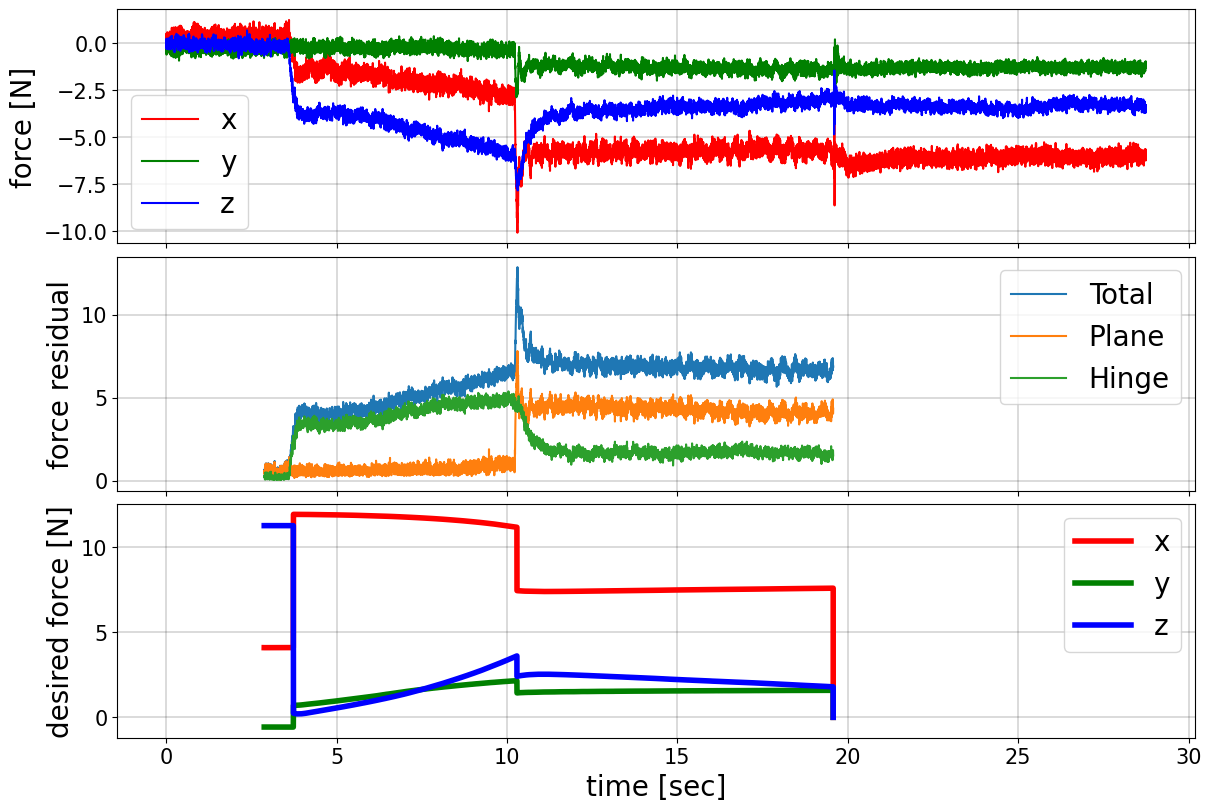

Loading ros bag /home/christian/Projects/contact_monitoring/data/online_rake_2.bag  with 7480 msgs on topic /contact_mode
Loading ros bag /home/christian/Projects/contact_monitoring/data/online_rake_2.bag  with 9637 msgs on topic /wrench
Loading ros bag /home/christian/Projects/contact_monitoring/data/online_rake_2.bag  with 7484 msgs on topic /target_wrench


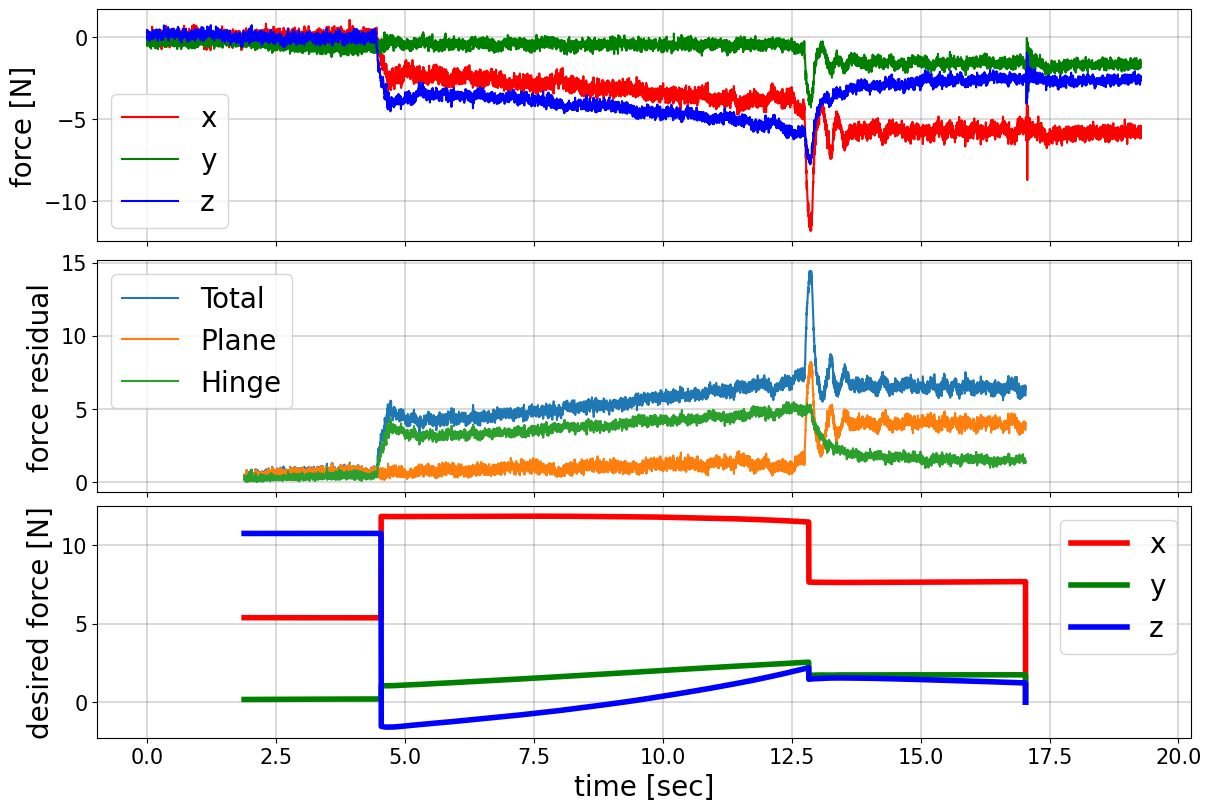

Loading ros bag /home/christian/Projects/contact_monitoring/data/online_rake_3.bag  with 9311 msgs on topic /contact_mode
Loading ros bag /home/christian/Projects/contact_monitoring/data/online_rake_3.bag  with 11755 msgs on topic /wrench
Loading ros bag /home/christian/Projects/contact_monitoring/data/online_rake_3.bag  with 9300 msgs on topic /target_wrench


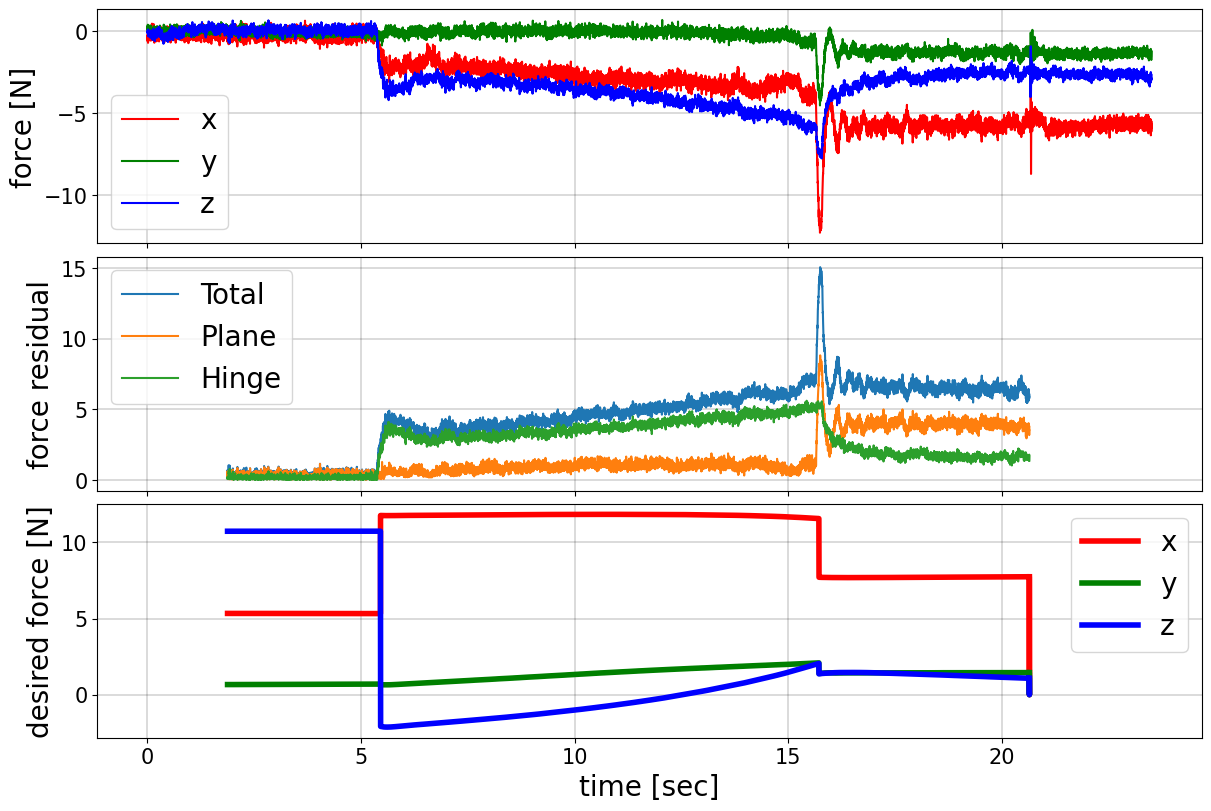

Loading ros bag /home/christian/Projects/contact_monitoring/data/online_rake_4.bag  with 9074 msgs on topic /contact_mode
Loading ros bag /home/christian/Projects/contact_monitoring/data/online_rake_4.bag  with 10926 msgs on topic /wrench
Loading ros bag /home/christian/Projects/contact_monitoring/data/online_rake_4.bag  with 9078 msgs on topic /target_wrench


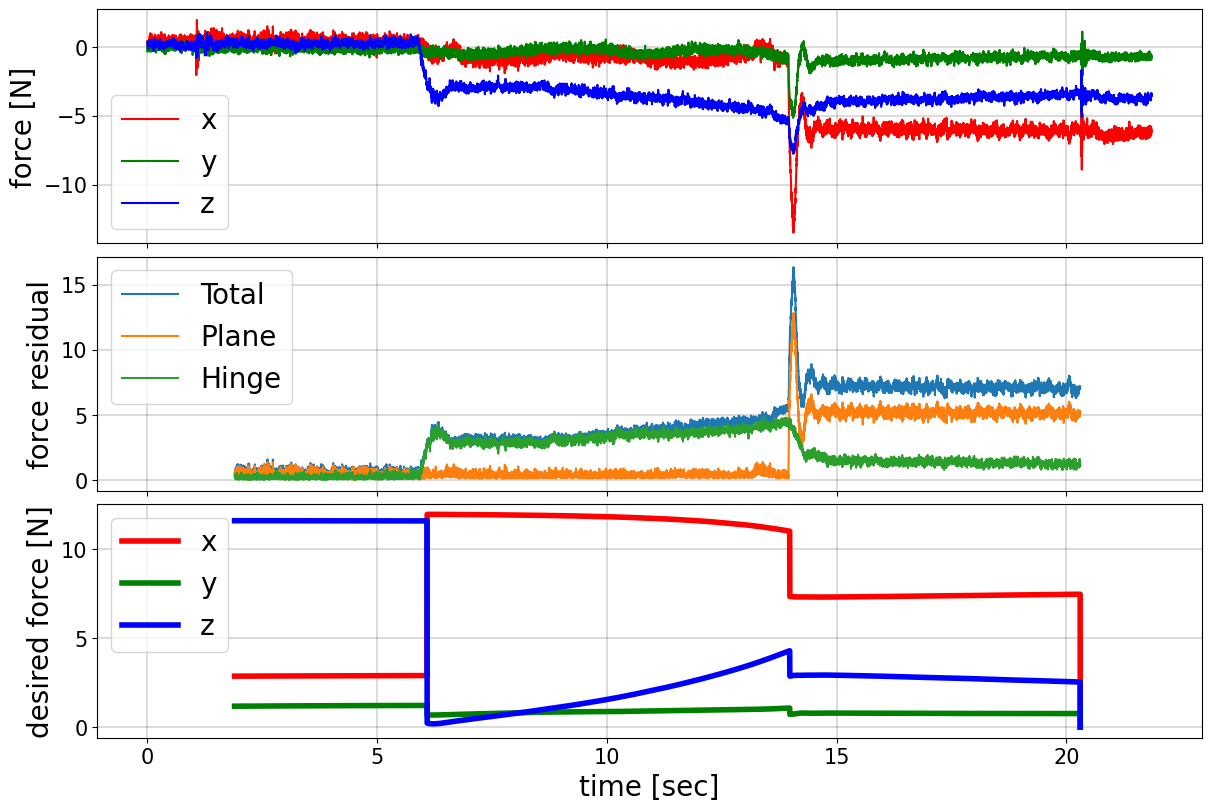

In [183]:
path = '/home/christian/Projects/contact_monitoring/'

bags = ["data/online_rake_1.bag",
"data/online_rake_2.bag",
"data/online_rake_3.bag",
"data/online_rake_4.bag",
]

for bag in bags:
    contact_state_msgs = bag_loader(path+bag, map_joint_state, topic_name = 'contact_mode')
    FT_msgs = bag_loader(path+bag, map_wrench, topic_name = 'wrench')
    des_FT_msgs = bag_loader(path+bag, map_wrench, topic_name = 'target_wrench')

    FT_des = des_FT_msgs['force']
    FT_f = FT_msgs['force']
    Contact = contact_state_msgs['pos']
    
    #time (offset by min t_start)
    time_contact = list(contact_state_msgs['t'])
    time_FT = np.array(list(FT_msgs['t']))
    time_FT_des = np.array(list(des_FT_msgs['t']))
    t_start = min(min(time_FT),min(time_contact),min(time_FT_des))
    time_contact -= t_start
    time_FT -= t_start
    time_FT_des -= t_start
    
    fig, ax = plt.subplots(3, 1, sharex=True,figsize=(12,8), constrained_layout=True)

    ax[0].plot(time_FT, FT_f[0,:], color='r', label= "x")
    ax[0].plot(time_FT, FT_f[1,:], color='g', label= "y")
    ax[0].plot(time_FT, FT_f[2,:], color='b', label= "z")
    ax[0].set_ylabel("force [N]", fontsize=20)

    ax[1].plot(time_contact, Contact[0,:], label="Total")
    ax[1].plot(time_contact, Contact[1,:], label="Plane")
    ax[1].plot(time_contact, Contact[2,:], label="Hinge")
    #ax[1].set_xlabel("time [sec]", fontsize=20)
    ax[1].set_ylabel("force residual", fontsize=20)

    ax[2].plot(time_FT_des, FT_des[0,:], color='r', label="x", linewidth=4)
    ax[2].plot(time_FT_des, FT_des[1,:], color='g', label="y", linewidth=4)
    ax[2].plot(time_FT_des, FT_des[2,:], color='b', label="z", linewidth=4)
    ax[2].set_xlabel("time [sec]", fontsize=20)
    ax[2].set_ylabel("desired force [N]", fontsize=20)
    
    for i in range(3):
        ax[i].legend(fontsize=20)
        ax[i].tick_params(axis='both', which='major', labelsize=15)
        ax[i].grid(color='black', linestyle='-', linewidth=.2)


    plt.show()
    

Loading ros bag /home/christian/Projects/contact_monitoring/data/online_cable_threading_1.bag  with 19979 msgs on topic /contact_mode
Loading ros bag /home/christian/Projects/contact_monitoring/data/online_cable_threading_1.bag  with 21840 msgs on topic /wrench
Loading ros bag /home/christian/Projects/contact_monitoring/data/online_cable_threading_1.bag  with 19982 msgs on topic /target_wrench


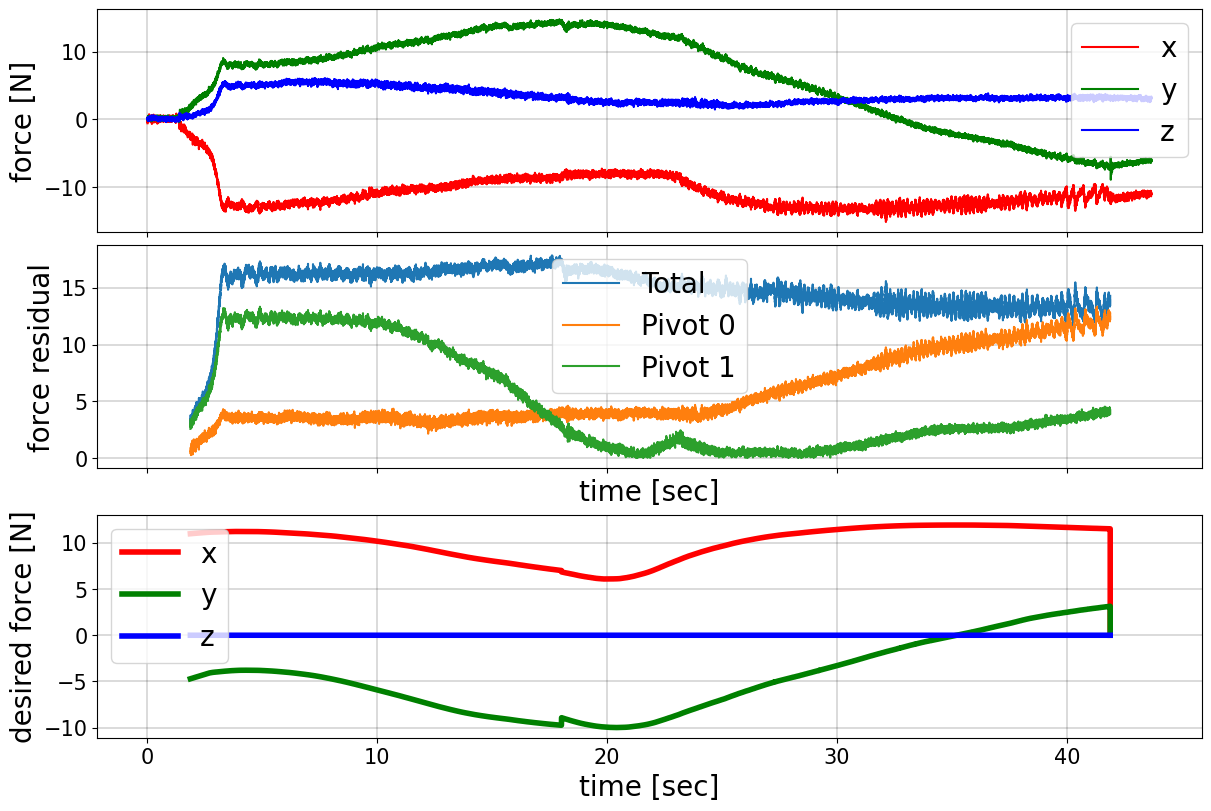

Loading ros bag /home/christian/Projects/contact_monitoring/data/online_threading_cable_2a.bag  with 22629 msgs on topic /contact_mode
Loading ros bag /home/christian/Projects/contact_monitoring/data/online_threading_cable_2a.bag  with 27645 msgs on topic /wrench
Loading ros bag /home/christian/Projects/contact_monitoring/data/online_threading_cable_2a.bag  with 22624 msgs on topic /target_wrench


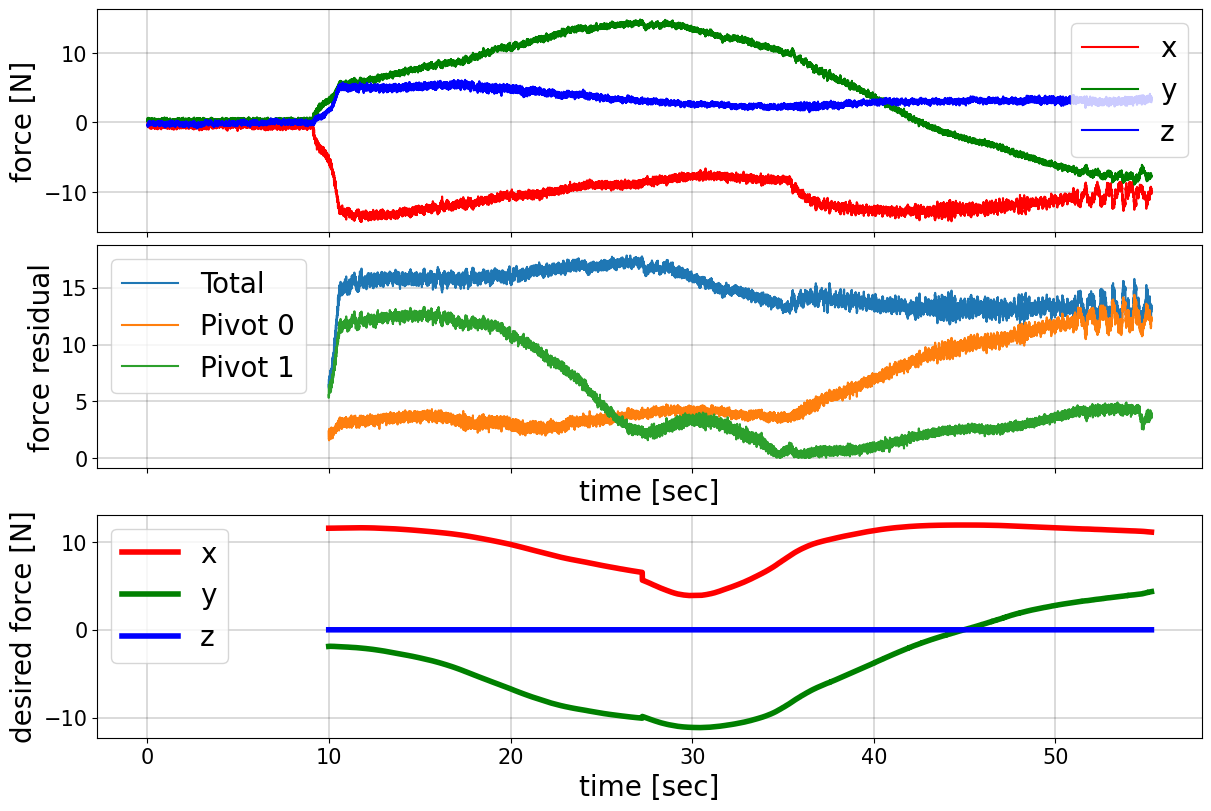

In [182]:
path = '/home/christian/Projects/contact_monitoring/data/'

bags = ['online_cable_threading_1.bag', 'online_threading_cable_2a.bag']

for bag in bags:
    contact_state_msgs = bag_loader(path+bag, map_joint_state, topic_name = 'contact_mode')
    FT_msgs = bag_loader(path+bag, map_wrench, topic_name = 'wrench')
    des_FT_msgs = bag_loader(path+bag, map_wrench, topic_name = 'target_wrench')

    FT_des = des_FT_msgs['force']
    FT_f = FT_msgs['force']
    Contact = contact_state_msgs['pos']
    
    #time (offset by min t_start)
    time_contact = list(contact_state_msgs['t'])
    time_FT = np.array(list(FT_msgs['t']))
    time_FT_des = np.array(list(des_FT_msgs['t']))
    
    t_start = min(min(time_FT),min(time_contact),min(time_FT_des))
    #t_start = min(min(time_FT),min(time_contact))
    time_contact -= t_start
    time_FT -= t_start
    time_FT_des -= t_start
    
    fig, ax = plt.subplots(3, 1, sharex=True,figsize=(12,8), constrained_layout=True)

    ax[0].plot(time_FT, FT_f[0,:], color='r', label= "x")
    ax[0].plot(time_FT, FT_f[1,:], color='g', label= "y")
    ax[0].plot(time_FT, FT_f[2,:], color='b', label= "z")
    ax[0].set_ylabel("force [N]", fontsize=20)

    ax[1].plot(time_contact, Contact[0,:], label="Total")
    ax[1].plot(time_contact, Contact[1,:], label="Pivot 0")
    ax[1].plot(time_contact, Contact[2,:], label="Pivot 1")
    ax[1].set_xlabel("time [sec]", fontsize=20)
    ax[1].set_ylabel("force residual", fontsize=20)
    
    
    ax[2].plot(time_FT_des, FT_des[0,:], color='r', label="x", linewidth=4)
    ax[2].plot(time_FT_des, FT_des[1,:], color='g', label="y", linewidth=4)
    ax[2].plot(time_FT_des, FT_des[2,:], color='b', label="z", linewidth=4)
    ax[2].set_xlabel("time [sec]", fontsize=20)
    ax[2].set_ylabel("desired force [N]", fontsize=20)
    
    
    for i in range(3):
        ax[i].legend(fontsize=20)
        ax[i].tick_params(axis='both', which='major', labelsize=15)
        ax[i].grid(color='black', linestyle='-', linewidth=.2)


    plt.show()